In [3]:
import sys

import SSLimPy.interface.sslimpy as sslimpy
from SSLimPy.LIMsurvey import PowerSpectra as pobs

import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.special import legendre

import astropy.units as u
import astropy.constants as cu

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import copy

#from fast_interp import interp1d

kitsune   = '#D9972F'
seiheki   = '#478384'
shuan     = '#740A00'
aonibi      = '#324356'
shion       = '#968ABD'

matplotlib.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"
colors = ['#9e1b1b','#6cb6c4',kitsune,'#a152d9','#0b3e45','#46b52b','#787575']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

%matplotlib inline

### Set functions

In [4]:
# Tools

def nu_from_lambda(lam):
    return (cu.c/lam).to(u.MHz)

def lambda_from_nu(nu):
    return (cu.c/nu).to(u.um)

def plot_2d(covmat,index,center,ax,color1,color2,TwoSigma=True,filled=True,factors=None,alpha=[1,1],zorder=1):
    '''
    Paints 2d ellipses representing forecast constraints from the Fisher matrix. 
    Uses https://arxiv.org/pdf/0906.4123.pdf
    '''
    #Define the 2x2 covariance matrix from the covariance matrix obtained from the inverse of the Fisher
    matrix = covmat[np.ix_(index,index)]
    clr = [color1,color2]
    #Rescale the errors if needed
    if factors: 
        s1 = matrix[0,0]**0.5*factors[0]
        s2 = matrix[1,1]**0.5*factors[1]
        s12 = matrix[0,1]*factors[0]*factors[1]
        center[0] *= factors[0]
        center[1] *= factors[1]
    else:
        s1 = matrix[0,0]**0.5
        s2 = matrix[1,1]**0.5
        s12 = matrix[0,1]
        
    rho = s12/s1/s2
    #print 'correlation =', rho
    #1sigma and 2sigma Delta chi2
    Deltachi2 = 2.3
    TwoSigmaDeltachi2 = 6.17
    
    xpar = np.linspace(-4*s1,4*s1,64)
    ypar = np.linspace(-4*s2,4*s2,64)
    xi_grid, yi_grid = np.meshgrid(xpar,ypar)
    #Define contours (ellipses) corresponding to chi2
    chi2 = ((xi_grid/s1)**2+(yi_grid/s2)**2-2.*rho*(xi_grid/s1)*(yi_grid/s2))/(1-rho**2)
    
    #Paint the contours
    if filled:
        if TwoSigma:
            ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,TwoSigmaDeltachi2],colors=clr[1],alpha=alpha[1])
        ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,Deltachi2],colors=clr[0],alpha=alpha[0])
    if TwoSigma:
        ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[TwoSigmaDeltachi2],colors=clr[1],linewidths=1,alpha=alpha[0])
    ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[Deltachi2],colors=clr[0],linewidths=1,alpha=alpha[0])

    ax.scatter(center[0],center[1],marker='o',color='k',s=20,zorder=6,edgecolors='k',lw=1)
    return


In [5]:
# Get intermediate quantities

def get_kvec(Vsurvey):
    '''
    Get the kvector for a given survey volume 
    '''
    Vsurvey = Vsurvey.to(u.Mpc**3)
    kmin = 2*np.pi/Vsurvey**(1/3)
    kmax = 0.1/u.Mpc
    kvec_edge = np.arange(kmin.value,kmax.value,kmin.value)*kmin.unit
    kvec = 0.5*(kvec_edge[:-1]+kvec_edge[1:])
    return kvec

def get_volume(M,Omega_field,zc,dz):
    '''
    Get the probed volume as function of area, z_center (zc) and redshift bin width (dz)
    '''
    zmin,zmax = zc-0.5*dz,zc+0.5*dz
    Lside = M.fiducialcosmo.comoving(zmax)-M.fiducialcosmo.comoving(zmin)
    Stot = M.fiducialcosmo.comoving(zc)**2*(Omega_field/(1.*u.rad**2)).decompose()
    return Lside*Stot

def THI_mean(z):
    '''
    Mean T_HI temperature
    '''
    return (0.0559+0.2324*z-0.024*z**2)*u.mK

def bHI_mean(z):
    '''
    mean HI bias
    '''
    return 0.67+0.18*z+0.05*z**2

def bg_DESI_4MOST_mean(z):
    '''
    mean galaxy bias for DESI and 4MOST
    '''
    return np.sqrt(1+z)

def get_beam(zc,D):
    ''''
    Get the beam width as function of diameter, redshift
    '''
    nuHI = nu_from_lambda(21*u.cm)
    return (1.22*cu.c/nuHI*(1+zc)/D).decompose()*u.rad

def B_beam(k,mu,zc,beam,M):
    '''
    Beam smoothing
    '''
    return np.exp(-k[:,None]**2*(1-mu[None,:]**2)*(M.fiducialcosmo.angdist(zc)*(1+zc)*beam/u.rad)**2/(16*np.log(2)))

#def fg_removal(k,mu,kpar_thresh):
#    '''
#    Applies the loss of information after foreground removal
#    '''
#    W = np.exp(-kpar_thresh/(k[:,None]*mu[None,:]))
#    return W

def prep_broadband(k,M,npoles=2):
    '''
    Prepares the spline for the broadband
    '''
    Delta = 2*np.pi/(147*u.Mpc)
    n_max = int((k[-1]-k[0])/Delta)+1
    # W3 is the Piecewise Cubic Spline (fourth-order) interpolation function
    x = np.fabs(np.array([k / Delta - (n - 1) for n in range(n_max)]))
    W3 = np.where(x <= 1, 4.0 - 6.0 * x**2 + 3.0 * x**3, np.where(x <= 2, (2.0 - x) ** 3, 0.0)) / 6.0
    # Store the W3 values in the broadband array
    poly_bb = np.zeros((n_max * npoles, npoles, len(k)))
    for i, pole in enumerate(range(npoles)):
        poly_bb[n_max * i : n_max * (i + 1), pole] = W3
    return n_max, poly_bb
            
def add_bb(pkpoles,coeffs,bb,n_max,npoles):
    '''
    adds the broadband spline to the Pk multipoles
    '''
    pkmuls = copy.deepcopy(pkpoles)
    count = 0
    for j,pole in enumerate(range(npoles)):
        for n,ip in enumerate(range(n_max)):
            if n_max == 3 and j == 1:
                count = 1
            else:
                count = 0
            pkmuls[j] += coeffs[npoles*j+n+count]*bb[npoles*j+n+count,pole,:]*pkpoles[0].unit
    return pkmuls
            
           
            
            
    

In [6]:
#Power spectrum

def get_multipoles(k,mu,pk):
    '''
    Gets the P(k) multipoles from P(k,mu), including the broad-band polynomials. 
    We're not adding the polynomia to marginalize over (yet)
    '''
    L2 = legendre(2)(mu)
    
    PK0 = 0.5*np.trapz(pk,mu,axis=1)
    PK2 = 2.5*np.trapz(pk*L2[None,:],mu,axis=1)
    
    return PK0,PK2



def AP_vecs(k,mu,alpha_par,alpha_perp):
    '''
    Gets the kprime, muprime for AP effect
    '''
    F = alpha_par/alpha_perp
    prefac = 1./alpha_perp**2/alpha_par
    
    #Get "real" k and mu
    mu_prime = mu/F/np.sqrt(1.+mu**2.*(1./F/F-1))
    kprime = k[:,None]/alpha_perp*np.sqrt(1.+mu[None,:]**2*(1./F/F-1))

    return kprime,mu_prime,prefac


            
def PkHI_auto_kmu(M,k,mu,zc,params):
    '''
    Get the HI power spectrum as function of measured k and mu and
    parameters to constrain/marginalize over "params"
    '''
    #get the parameters
    alpha_par,alpha_perp, fNL, beam, Tbs8, f, bgs8 = params
    
    kprime,mu_prime,prefac = AP_vecs(k,mu,alpha_par,alpha_perp)
    beta = f/bHI_mean(zc)

    #Apply RSD for the "real" mu and get the Pk
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    PK = np.zeros(kprime.shape)
    for i in range(kprime.shape[0]):
        PK[i,:] = M.dewiggled_pdd(kprime[i,:],zc,mu_prime[i])
    PK = PK*u.Mpc**3/s8**2
    kaiser = (1.+beta*mu_prime**2)**2
    sigma_fog = M.fiducialcosmo.P_ThetaTheta_Moments(zc,0)
    loren = 1./(1.+0.5*(kprime*mu_prime[None,:]*sigma_fog)**2)**2

    #build total Pk
    if fNL == 0:
        Pkmu = prefac*(Tbs8)**2*kaiser*loren*PK*B_beam(k,mu,zc,beam,M)**2
    else:
        Tk = get_transfer(M,k,zc)
        D = M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,zc)/M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,0)
        factor = 1.686*3*M.fiducialcosmo.Omega(0)*M.fiducialcosmo.Hubble(0,physical=True).to(u.km/u.s/u.Mpc)**2/cu.c**2/k**2/Tk/D
        bg = bHI_mean(zc)
        Pkmu = prefac*(Tbs8*(1+(1-1/bg)*fNL*factor[:,None]))**2*kaiser[None,:]*loren*PK*B_beam(k,mu,zc,beam,M)**2
    return Pkmu

def Pkgal_auto_kmu(M,k,mu,zc,params):
    '''
    Get the galaxy power spectrum as function of measured k and mu and
    parameters to constrain/marginalize over "params"
    '''
    #get the parameters
    alpha_par,alpha_perp, fNL, beam, Tbs8_HI, f, bgs8 = params
    
    kprime,mu_prime,prefac = AP_vecs(k,mu,alpha_par,alpha_perp)

    #Apply RSD for the "real" mu and get the Pk
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    bg = bgs8/s8
    beta = f/bg
    PK = np.zeros(kprime.shape)
    for i in range(kprime.shape[0]):
        PK[i,:] = M.dewiggled_pdd(kprime[i,:],zc,mu_prime[i])
    PK = PK*u.Mpc**3/s8**2
    kaiser = (1.+beta*mu_prime**2)**2
    sigma_fog = M.fiducialcosmo.P_ThetaTheta_Moments(zc,0)
    loren = 1./(1.+0.5*(kprime*mu_prime[None,:]*sigma_fog)**2)**2

    #build total Pk
    if fNL == 0:
        Pkmu = prefac*(bgs8)**2*kaiser*loren*PK
    else:
        Tk = get_transfer(M,k,zc)
        D = M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,zc)/M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,0)
        factor = 1.686*3*M.fiducialcosmo.Omega(0)*M.fiducialcosmo.Hubble(0,physical=True).to(u.km/u.s/u.Mpc)**2/cu.c**2/k**2/Tk/D
        Pkmu = prefac*(bgs8*(1+(1-1/bg)*fNL*factor[:,None]))**2*kaiser[None,:]*loren*PK
    return Pkmu

def PkHIgal_cross_kmu(M,k,mu,zc,params):
    '''
    Get the HIxgal power spectrum as function of measured k and mu and
    parameters to constrain/marginalize over "params"
    '''
    #get the parameters
    alpha_par,alpha_perp, fNL, beam, Tbs8_HI, f, bgs8 = params
    
    kprime,mu_prime,prefac = AP_vecs(k,mu,alpha_par,alpha_perp)
    beta_HI = f/bHI_mean(zc)

    #Apply RSD for the "real" mu and get the Pk
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    bg = bgs8/s8
    beta_g = f/bg
    PK = np.zeros(kprime.shape)
    for i in range(kprime.shape[0]):
        PK[i,:] = M.dewiggled_pdd(kprime[i,:],zc,mu_prime[i])
    PK = PK*u.Mpc**3/s8**2
    kaiser = (1.+beta_g*mu_prime**2)*(1.+beta_HI*mu_prime**2)
    sigma_fog = M.fiducialcosmo.P_ThetaTheta_Moments(zc,0)
    loren = 1./(1.+0.5*(kprime*mu_prime[None,:]*sigma_fog)**2)**2

    #build total Pk
    if fNL == 0:
        Pkmu = prefac*(Tbs8_HI)*bgs8*kaiser*loren*PK*B_beam(k,mu,zc,beam,M)
    else:
        Tk = get_transfer(M,k,zc)
        D = M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,zc)/M.fiducialcosmo.growth_factor(0.05*u.Mpc**-1,0)
        factor = 1.686*3*M.fiducialcosmo.Omega(0)*M.fiducialcosmo.Hubble(0,physical=True).to(u.km/u.s/u.Mpc)**2/cu.c**2/k**2/Tk/D
        bGHI = bHI_mean(zc)
        Pkmu = prefac*(Tbs8_HI*(1+(1-1/bGHI)*fNL*factor[:,None]))*(bgs8*(1+(1-1/bg)*fNL*factor[:,None]))*kaiser[None,:]*loren*PK*B_beam(k,mu,zc,beam,M)
    return Pkmu

def get_transfer(M,k,zc):
    kdum = np.geomspace(1e-5,1,300)*u.Mpc**-1
    Tkdum = kdum**-2*M.fiducialcosmo.Transfer(kdum,zc,tracer="clustering")
    Tkdum *= 1/np.max(Tkdum)

    return interp1d(kdum,Tkdum)(k)

In [7]:
# covariance

def Tsys(zc):
    '''
    Returns the effective system temperature as function of z
    '''
    nuObs = np.array([5.800000000000000000e+02,6.000000000000000000e+02, 6.500000000000000000e+02, 7.000000000000000000e+02, 
                      7.500000000000000000e+02, 8.000000000000000000e+02, 8.500000000000000000e+02, 9.000000000000000000e+02, 
                       9.500000000000000000e+02, 1.000000000000000000e+03])
    Tsys= np.array([3.145097253000000137e+01, 3.030244111000000018e+01, 2.793684247999999926e+01, 2.610862067000000053e+01, 
                   2.465761523999999838e+01, 2.347801079999999985e+01, 2.249790518000000006e+01, 2.166722859000000057e+01, 
                   2.095035455000000013e+01, 2.032144411000000161e+01])

    nuHI = nu_from_lambda(21*u.cm)
    nuHI_Obs = nuHI/(1+zc)

    fsys = 0.72
    
    Tsys_nu = interp1d(nuObs,Tsys)(nuHI_Obs)*u.K*fsys
    return Tsys_nu

def Pnoise(M,zc,Omega_field,tobs,Nd):
    '''
    Returns the instrumental noise power spectrum
    '''
    nuHI = nu_from_lambda(21*u.cm)
    T_sys = Tsys(zc)
    H = M.fiducialcosmo.Hubble(zc,physical=True).to(u.km/u.s/u.Mpc)
    
    Pn = T_sys**2*Omega_field.to(u.sr)/u.sr/(2*Nd*tobs)*cu.c/nuHI*(M.fiducialcosmo.angdist(zc)**2*(1+zc)**4)/H
    return Pn.to(u.Mpc**3*u.mK**2)

def Nmodes(k,V):
    '''
    Returns the number of modes in each kbin
    '''
    dk = k[1]-[0]
    return k**2*dk*V/4./np.pi**2.

def covarianceHI_auto(k,mu,Pkmu,Pnoise,V):
    '''
    Builds the covariance for monopole and quadrupole
    '''
    nk = len(k)
    Cov = np.zeros((2*nk,2*nk))
    N_modes = Nmodes(k,V)
    L2 = legendre(2)(mu)
    
    integ = (Pkmu+Pnoise)/N_modes[:,None]**0.5
    Cov[:nk,:nk] = np.diag(0.5*np.trapz(integ**2,mu,axis=1))
    Cov[:nk,nk:] = np.diag(2.5*np.trapz(integ**2*L2,mu,axis=1))
    Cov[nk:,:nk] = Cov[:nk,nk:]
    Cov[nk:,nk:] = np.diag(25/2*np.trapz(integ**2*L2*L2,mu,axis=1))

    return Cov

def covariancegal_auto(k,mu,Pkmu,ngal,V):
    '''
    Builds the covariance for monopole and quadrupole
    '''
    nk = len(k)
    Cov = np.zeros((2*nk,2*nk))
    N_modes = Nmodes(k,V)
    L2 = legendre(2)(mu)
    
    integ = (Pkmu+1/ngal)/N_modes[:,None]**0.5
    Cov[:nk,:nk] = np.diag(0.5*np.trapz(integ**2,mu,axis=1))
    Cov[:nk,nk:] = np.diag(2.5*np.trapz(integ**2*L2,mu,axis=1))
    Cov[nk:,:nk] = Cov[:nk,nk:]
    Cov[nk:,nk:] = np.diag(25/2*np.trapz(integ**2*L2*L2,mu,axis=1))

    return Cov

def covariance_multi(k,mu,PHI,Pg,Pcross,Pnoise,ngal,V):
    '''
    BUilds the full covariance matrix for the multitracer case
    '''
    nk = len(k)
    Cov = np.zeros((2*nk*3,2*nk*3))
    N_modes = Nmodes(k,V)
    L2 = legendre(2)(mu)

    integHI = (PHI+Pnoise)/N_modes[:,None]**0.5
    integgal = (Pg+1/ngal)/N_modes[:,None]**0.5
    integcross = 0.5*((Pg+1/ngal)*(PHI+Pnoise)+Pcross**2)/N_modes[:,None]**0.5
    integcross_2 = (Pcross)/N_modes[:,None]**0.5

    Cov[:nk,:nk] = np.diag(0.5*np.trapz(integHI**2,mu,axis=1))
    Cov[:nk,nk:2*nk] = np.diag(2.5*np.trapz(integHI**2*L2,mu,axis=1))
    Cov[nk:2*nk,:nk] = Cov[:nk,nk:2*nk]
    Cov[nk:2*nk,nk:2*nk] = np.diag(25/2*np.trapz(integHI**2*L2*L2,mu,axis=1))

    Cov[2*nk:3*nk,:nk] = np.diag(0.5*np.trapz(integHI*integcross_2,mu,axis=1))
    Cov[3*nk:4*nk,:nk] = np.diag(2.5*np.trapz(integHI*integcross_2*L2,mu,axis=1))
    Cov[2*nk:3*nk,nk:2*nk] = Cov[3*nk:4*nk,:nk]
    Cov[3*nk:4*nk,nk:2*nk] = np.diag(25/2*np.trapz(integHI*integcross_2*L2*L2,mu,axis=1))

    Cov[4*nk:5*nk,:nk] = np.diag(0.5*np.trapz(integcross_2**2,mu,axis=1))
    Cov[5*nk:,:nk] = np.diag(2.5*np.trapz(integcross_2**2*L2,mu,axis=1))
    Cov[4*nk:5*nk,nk:2*nk] = Cov[5*nk:,:nk]
    Cov[5*nk:,nk:2*nk] = np.diag(25/2*np.trapz(integcross_2**2*L2*L2,mu,axis=1))   

    Cov[2*nk:3*nk,2*nk:3*nk] = np.diag(0.5*np.trapz(integcross,mu,axis=1))
    Cov[2*nk:3*nk,3*nk:4*nk] = np.diag(2.5*np.trapz(integcross*L2,mu,axis=1))
    Cov[3*nk:4*nk,2*nk:3*nk] = Cov[2*nk:3*nk,3*nk:4*nk]
    Cov[3*nk:4*nk,3*nk:4*nk] = np.diag(25/2*np.trapz(integcross*L2*L2,mu,axis=1))       

    Cov[4*nk:5*nk,2*nk:3*nk] = np.diag(0.5*np.trapz(integgal*integcross_2,mu,axis=1))
    Cov[4*nk:5*nk,3*nk:4*nk] = np.diag(2.5*np.trapz(integgal*integcross_2*L2,mu,axis=1))
    Cov[5*nk:,2*nk:3*nk] = Cov[4*nk:5*nk,3*nk:4*nk]
    Cov[5*nk:,3*nk:4*nk] = np.diag(25/2*np.trapz(integgal*integcross_2*L2*L2,mu,axis=1))

    Cov[4*nk:5*nk,4*nk:5*nk] = np.diag(0.5*np.trapz(integgal**2,mu,axis=1))
    Cov[4*nk:5*nk,5*nk:] = np.diag(2.5*np.trapz(integgal**2*L2,mu,axis=1))
    Cov[5*nk:,4*nk:5*nk] = Cov[4*nk:5*nk,5*nk:]
    Cov[5*nk:,5*nk:] = np.diag(25/2*np.trapz(integgal**2*L2*L2,mu,axis=1))

    Cov[:2*nk,2*nk:4*nk] = Cov[2*nk:4*nk,:2*nk]
    Cov[:2*nk,4*nk:] = Cov[4*nk:,:2*nk]
    Cov[2*nk:4*nk,4*nk:] = Cov[4*nk:,2*nk:4*nk]

    return Cov


In [16]:
#Do the fisher
def do_fisher(M,zc,dz,Omega_field,tobs,Nd,ngal,bg,kind):
    '''
    Do the fisher matrix for a volume centered at zc over a bin of width dz and area Omega_field
    observing a total of tobs with Nd detectors, and a potential cross with a galaxy survey
    with ngal number density and bias bg
    '''
    THI = THI_mean(zc)
    bHI = bHI_mean(zc)
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    Tbs8 = THI*bHI*s8
    f = M.fiducialcosmo.growth_rate(0.08/u.Mpc,zc,'clustering')
    D = 13.5*u.m #Diameter of dish
    beam = get_beam(zc,D)
    npoles = 2

    #derived from survey
    V = get_volume(M,Omega_field,zc,dz)
    kvec = get_kvec(V)
    mu = np.linspace(-1,1,128)
    nmax, bb = prep_broadband(kvec,M,npoles=npoles)
    
    if kind == 'auto':
        #prep params
        fiducial_set = [1,1,0,beam,Tbs8,f,bg*s8]
        varying_set = [1,1,0.,beam,Tbs8,f,bg*s8]
        coeff_set = [0]*nmax*npoles

        #compute fiducial and noise => covariance
        Pkmu = PkHI_auto_kmu(M,kvec,mu,zc,fiducial_set)
        PN = Pnoise(M,zc,Omega_field,tobs,Nd)
        pk0,pk2 = get_multipoles(kvec,mu,Pkmu)

        CO = covarianceHI_auto(kvec,mu,Pkmu,PN,V)
        invCO = np.linalg.inv(CO)

        FISHER = compute_fisher_auto(fiducial_set, varying_set, coeff_set,kvec,mu,pk0,pk2,invCO,nmax,bb)
        return FISHER

    elif kind == 'gal':
        #prep params
        fiducial_set = [1,1,0,beam,Tbs8,f,bg*s8]
        varying_set = [1,1,0.,beam,Tbs8,f,bg*s8]
        coeff_set = [0]*nmax*npoles

        #compute fiducial and noise => covariance
        Pkmugal = Pkgal_auto_kmu(M,kvec,mu,zc,fiducial_set)
        pk0gal,pk2gal = get_multipoles(kvec,mu,Pkmugal)

        CO = covariancegal_auto(kvec,mu,Pkmugal,ngal,V)
        invCO = np.linalg.inv(CO)

        FISHER = compute_fisher_gal_auto(fiducial_set, varying_set, coeff_set,kvec,mu,pk0gal,pk2gal,invCO,nmax,bb)
        return FISHER

    elif kind == 'multi':
        #prep params
        fiducial_set = [1,1,0,beam,Tbs8,f,bg*s8]
        varying_set = [1,1,0.,beam,Tbs8,f,bg*s8]
        coeff_set = [0]*nmax*npoles*3

        #compute fiducial and noise => covariance
        PkmuHI = PkHI_auto_kmu(M,kvec,mu,zc,fiducial_set)
        pk0HI,pk2HI = get_multipoles(kvec,mu,PkmuHI)
        Pkmugal = Pkgal_auto_kmu(M,kvec,mu,zc,fiducial_set)
        pk0gal,pk2gal = get_multipoles(kvec,mu,Pkmugal)
        Pkmucross = PkHIgal_cross_kmu(M,kvec,mu,zc,fiducial_set)
        pk0cross,pk2cross = get_multipoles(kvec,mu,Pkmucross)

        PN = Pnoise(M,zc,Omega_field,tobs,Nd)
        CO = covariance_multi(kvec,mu,PkmuHI,Pkmugal,Pkmucross,PN,ngal,V)
        invCO = np.linalg.inv(CO)

        FISHER = compute_fisher_multi(fiducial_set, varying_set, coeff_set,kvec,mu,
                                      pk0HI,pk2HI,pk0cross,pk2cross,pk0gal,pk2gal,invCO,nmax,bb)
        return FISHER

    else:
        print('You need to choose kind == auto or multi or gal')
        return


def compute_fisher_multi(fiducial_set, varying_set, coeff_set,kvec,mu,
                        pk0_HI,pk2_HI,pk0_cross,pk2_cross,pk0_gal,pk2_gal,invCO,nmax,bb):
    '''
    Computes the Fisher matrix from the derivatives for the multitracer case
    '''
    npoles = 2
    NCOS = len(fiducial_set)-1 #We don't include bgs8
    NCOEFF = len(coeff_set)
    NPAR = NCOS+NCOEFF
    FISHER = np.zeros((NPAR,NPAR))
    ders = np.zeros((NPAR,len(kvec)*6))

    #derivatives for cosmo parameters
    for ip in range(NCOS):
        if fiducial_set[ip]!=0:
            dpar = 1.002*fiducial_set[ip]-0.998*fiducial_set[ip]
            varying_set[ip] = fiducial_set[ip]*1.002
        else:
            dpar = 0.2
            varying_set[ip] = dpar/2
        Pkmu_plus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0HI_plus,pk2HI_plus = get_multipoles(kvec,mu,Pkmu_plus)
        Pkmu_plus = PkHIgal_cross_kmu(M,kvec,mu,zc,varying_set)
        pk0cross_plus,pk2cross_plus = get_multipoles(kvec,mu,Pkmu_plus)
        Pkmu_plus = Pkgal_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0gal_plus,pk2gal_plus = get_multipoles(kvec,mu,Pkmu_plus)
        if fiducial_set[ip]!=0:
            varying_set[ip] = fiducial_set[ip]*0.998
        else:
            varying_set[ip] = -dpar/2
        Pkmu_minus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0_minus,pk2_minus = get_multipoles(kvec,mu,Pkmu_minus)
        pk0HI_minus,pk2HI_minus = get_multipoles(kvec,mu,Pkmu_minus)
        Pkmu_minus = PkHIgal_cross_kmu(M,kvec,mu,zc,varying_set)
        pk0cross_minus,pk2cross_minus = get_multipoles(kvec,mu,Pkmu_minus)
        Pkmu_minus = Pkgal_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0gal_minus,pk2gal_minus = get_multipoles(kvec,mu,Pkmu_minus)  
        
        ders[ip] = np.concatenate((pk0HI_plus.value-pk0HI_minus.value,pk2HI_plus.value-pk2HI_minus.value,
                                   pk0cross_plus.value-pk0cross_minus.value,pk2cross_plus.value-pk2cross_minus.value,
                                   pk0gal_plus.value-pk0gal_minus.value,pk2gal_plus.value-pk2gal_minus.value))/dpar
        varying_set[ip] = fiducial_set[ip]

    #derivatives for nuisance parameters (broadband)
    null = np.zeros(len(pk0_HI))
    for jp in range(NCOEFF):
        if jp < NCOEFF/3:
            pkpoles = [pk0_HI,pk2_HI]
            dpar = 0.02
            coeff_set[jp] = dpar/2
            pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set[:int(NCOEFF/3)],bb,nmax,npoles)
        
            coeff_set[jp] = -dpar/2
            pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set[:int(NCOEFF/3)],bb,nmax,npoles)
        
            ders[jp+NCOS] = np.concatenate((pk0_plus.value-pk0_minus.value,pk2_plus.value-pk2_minus.value,null,null,null,null))/dpar
            coeff_set[jp] = 0.
        elif (jp >= NCOEFF/3) and (jp<2*NCOEFF/3):
            pkpoles = [pk0_cross,pk2_cross]
            dpar = 0.02
            coeff_set[jp] = dpar/2
            pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set[int(NCOEFF/3):int(2*NCOEFF/3)],bb,nmax,npoles)
        
            coeff_set[jp] = -dpar/2
            pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set[int(NCOEFF/3):int(2*NCOEFF/3)],bb,nmax,npoles)
        
            ders[jp+NCOS] = np.concatenate((null,null,pk0_plus.value-pk0_minus.value,pk2_plus.value-pk2_minus.value,null,null))/dpar
            coeff_set[jp] = 0.
        else:
            pkpoles = [pk0_gal,pk2_gal]
            dpar = 0.02
            coeff_set[jp] = dpar/2
            pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set[int(2*NCOEFF/3):],bb,nmax,npoles)
        
            coeff_set[jp] = -dpar/2
            pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set[int(2*NCOEFF/3):],bb,nmax,npoles)
        
            ders[jp+NCOS] = np.concatenate((null,null,null,null,pk0_plus.value-pk0_minus.value,pk2_plus.value-pk2_minus.value))/dpar
            coeff_set[jp] = 0.

    #Compute Fisher Matrix
    for ip in range(NPAR):
        for jp in range(ip,NPAR):
            FISHER[ip,jp] = np.dot(ders[ip],np.dot(invCO,ders[jp]))
            FISHER[jp,ip] = FISHER[ip,jp]
            
    return FISHER

def compute_fisher_auto(fiducial_set, varying_set, coeff_set,kvec,mu,pk0,pk2,invCO,nmax,bb):
    '''
    Computes the Fisher matrix from the derivatives
    '''
    npoles = 2
    NCOS = len(fiducial_set)-1 #We don't include bgs8
    NCOEFF = len(coeff_set)
    print(kvec[0],kvec[-1],len(kvec))
    NPAR = NCOS+NCOEFF
    FISHER = np.zeros((NPAR,NPAR))
    ders = np.zeros((NPAR,len(pk0)*2))

    #derivatives for cosmo parameters
    for ip in range(NCOS):
        if fiducial_set[ip]!=0:
            dpar = 1.002*fiducial_set[ip]-0.998*fiducial_set[ip]
            varying_set[ip] = fiducial_set[ip]*1.002
        else:
            dpar = 0.2
            varying_set[ip] = dpar/2 
        Pkmu_plus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0_plus,pk2_plus = get_multipoles(kvec,mu,Pkmu_plus)
        if fiducial_set[ip]!=0:
            varying_set[ip] = fiducial_set[ip]*0.998
        else:
            varying_set[ip] = -dpar/2
        Pkmu_minus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
        pk0_minus,pk2_minus = get_multipoles(kvec,mu,Pkmu_minus)
    
        ders[ip] = np.concatenate((pk0_plus-pk0_minus,pk2_plus-pk2_minus))/dpar
        varying_set[ip] = fiducial_set[ip]

    #derivatives for nuisance parameters (broadband)
    pkpoles = [pk0,pk2]
    for jp in range(NCOEFF):
        dpar = 0.02
        coeff_set[jp] = dpar/2
        pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    
        coeff_set[jp] = -dpar/2
        pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    
        ders[jp+NCOS] = np.concatenate((pk0_plus-pk0_minus,pk2_plus-pk2_minus))/dpar
        coeff_set[jp] = 0.

    #Compute Fisher Matrix
    for ip in range(NPAR):
        for jp in range(ip,NPAR):
            FISHER[ip,jp] = np.dot(ders[ip],np.dot(invCO,ders[jp]))
            FISHER[jp,ip] = FISHER[ip,jp]
            
    return FISHER

def compute_fisher_gal_auto(fiducial_set, varying_set, coeff_set,kvec,mu,pk0,pk2,invCO,nmax,bb):
    '''
    Computes the Fisher matrix from the derivatives
    '''
    npoles = 2
    NCOS = len(fiducial_set)-1 #We don't include bgs8
    NCOEFF = len(coeff_set)
    print(kvec[0],kvec[-1],len(kvec))
    NPAR = NCOS+NCOEFF
    FISHER = np.zeros((NPAR,NPAR))
    ders = np.zeros((NPAR,len(pk0)*2))

    #derivatives for cosmo parameters
    for ip in range(NCOS):
        #HI only parameters!
        if ip == 3 or ip == 4:
            ders[ip] = np.zeros(len(pk0)*2)
        else:
            if fiducial_set[ip]!=0:
                dpar = 1.002*fiducial_set[ip]-0.998*fiducial_set[ip]
                varying_set[ip] = fiducial_set[ip]*1.002
            else:
                dpar = 0.2
                varying_set[ip] = dpar/2 
            Pkmu_plus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
            pk0_plus,pk2_plus = get_multipoles(kvec,mu,Pkmu_plus)
            if fiducial_set[ip]!=0:
                varying_set[ip] = fiducial_set[ip]*0.998
            else:
                varying_set[ip] = -dpar/2
            Pkmu_minus = PkHI_auto_kmu(M,kvec,mu,zc,varying_set)
            pk0_minus,pk2_minus = get_multipoles(kvec,mu,Pkmu_minus)
        
            ders[ip] = np.concatenate((pk0_plus-pk0_minus,pk2_plus-pk2_minus))/dpar
            varying_set[ip] = fiducial_set[ip]

    #derivatives for nuisance parameters (broadband)
    pkpoles = [pk0,pk2]
    for jp in range(NCOEFF):
        dpar = 0.02
        coeff_set[jp] = dpar/2
        pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    
        coeff_set[jp] = -dpar/2
        pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    
        ders[jp+NCOS] = np.concatenate((pk0_plus-pk0_minus,pk2_plus-pk2_minus))/dpar
        coeff_set[jp] = 0.

    #Compute Fisher Matrix
    for ip in range(NPAR):
        for jp in range(ip,NPAR):
            FISHER[ip,jp] = np.dot(ders[ip],np.dot(invCO,ders[jp]))
            FISHER[jp,ip] = FISHER[ip,jp]
    #Remove info from HI-only params
    FISHER[3,:] = 0
    FISHER[:,3] = 0
    FISHER[3,3] = 1e-40
    FISHER[4,:] = 0
    FISHER[:,4] = 0
    FISHER[4,4] = 1e-40
            
    return FISHER

### Define cosmology

In [9]:
cosmodict={"h":0.6774,"Omegam":0.31,"Omegab":0.05,"As":2.142e-9, "mnu":0.06, "ns":0.967}
settings = {"code":"class","TracerPowerSpectrum":"clustering"}

SSLIMPY = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict)
M = pobs.PowerSpectra(SSLIMPY.fiducialcosmo,SSLIMPY.fiducialastro)
Mpch = SSLIMPY.fiducialastro.Mpch

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#
requested Pk shape: (199, 127, 1)


### Assumptions

So far the parameters to forecast to are

$\left\lbrace\alpha_\parallel,\alpha_\perp,f_{\rm NL},\theta_{\rm beam},T_{\rm HI}b_{\rm HI}\sigma_8,f\right\rbrace$

which is a bit of a cheat because we can't separate $f$ from $T_{\rm HI}$, but let's ignore that. We marginalize over the broadband, as it's common for BAO analyses (each power spectra may have its own systematic, so we marginalize differently for each of them). We consider only HI auto and the multi with galaxies.

Some rough examples below. Blue is HI only, orange is with multi from galaxies.

If we want to constrain only fNL, we can ignore some of the parameters and have a different broadband marginalization.

### MK details

In [19]:
tobs = 1300*u.h
Nd = 60

### MeerKLASS x DESI

In [20]:
#MK Auto
ZZ = [0.65,0.8,1.,1.2]
DZ = [0.1,0.2,0.2,0.2]
FISHER_MK = []

Omega_field1 = 7.5e3*u.deg**2
Omega_field2 = 2.5e3*u.deg**2
ngal = (3.7e-4/Mpch**3).to(u.Mpc**-3)

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z1 = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MK2_z1 = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    FISHER_MK.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z1)[:NPAR,:NPAR]))



0.005876628492438332 1 / Mpc 0.09598493204315943 1 / Mpc 24
0.008475564918075457 1 / Mpc 0.09323121409883003 1 / Mpc 16
0.004301907517566078 1 / Mpc 0.09607593455897576 1 / Mpc 33
0.006204424268711886 1 / Mpc 0.09720264687648622 1 / Mpc 23
0.003999202858794437 1 / Mpc 0.09731393623066463 1 / Mpc 36
0.005767848604668436 1 / Mpc 0.09805342627936342 1 / Mpc 25
0.00381194621804344 1 / Mpc 0.09783995292978162 1 / Mpc 38
0.005497777795008101 1 / Mpc 0.09712740771180978 1 / Mpc 26


In [18]:
#MK Auto
ZZ = [0.65,0.8,1.,1.2]
DZ = [0.1,0.2,0.2,0.2]
FISHER_MKxDESI = []

Omega_field1 = 5.5e3*u.deg**2
Omega_field2 = 1.5e3*u.deg**2
ngal = (3.7e-4/Mpch**3).to(u.Mpc**-3)
Omega_field3 = 2e3*u.deg**2
Omega_field4 = 1e3*u.deg**2
Omega_field5 = 3e3*u.deg**2
Omega_field6 = 1.5e3*u.deg**2

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MK2_z = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MKxDESI1_z = do_fisher(M,zc,dz,Omega_field3,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'multi')
    Fisher_MKxDESI2_z = do_fisher(M,zc,dz,Omega_field4,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'multi')
    Fisher_DESI1_z = do_fisher(M,zc,dz,Omega_field5,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'gal')
    Fisher_DESI2_z = do_fisher(M,zc,dz,Omega_field6,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'gal')
    FISHER_MKxDESI.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxDESI1_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxDESI2_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_DESI1_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_DESI2_z)[:NPAR,:NPAR]))



0.006516700489299714 1 / Mpc 0.0977505073394957 1 / Mpc 22
0.010048893369624487 1 / Mpc 0.09044004032662038 1 / Mpc 13
0.007975811953029087 1 / Mpc 0.09305113945200602 1 / Mpc 17
0.010048893369624487 1 / Mpc 0.09044004032662038 1 / Mpc 13
0.004770463686911237 1 / Mpc 0.09699942830052849 1 / Mpc 30
0.007356158379865654 1 / Mpc 0.09563005893825349 1 / Mpc 19
0.005838586775321713 1 / Mpc 0.09536358399692131 1 / Mpc 24
0.007356158379865654 1 / Mpc 0.09563005893825349 1 / Mpc 19
0.004434788971303687 1 / Mpc 0.09608709437824654 1 / Mpc 32
0.00683854069441917 1 / Mpc 0.09346005615706199 1 / Mpc 20
0.005427753346124166 1 / Mpc 0.09589030911486027 1 / Mpc 26
0.00683854069441917 1 / Mpc 0.09346005615706199 1 / Mpc 20
0.004227136667950353 1 / Mpc 0.09722414336285813 1 / Mpc 34
0.006518336342879485 1 / Mpc 0.09777504514319227 1 / Mpc 22
0.00517360698388472 1 / Mpc 0.09484946137121987 1 / Mpc 27
0.006518336342879485 1 / Mpc 0.09777504514319227 1 / Mpc 22


z =  0.65


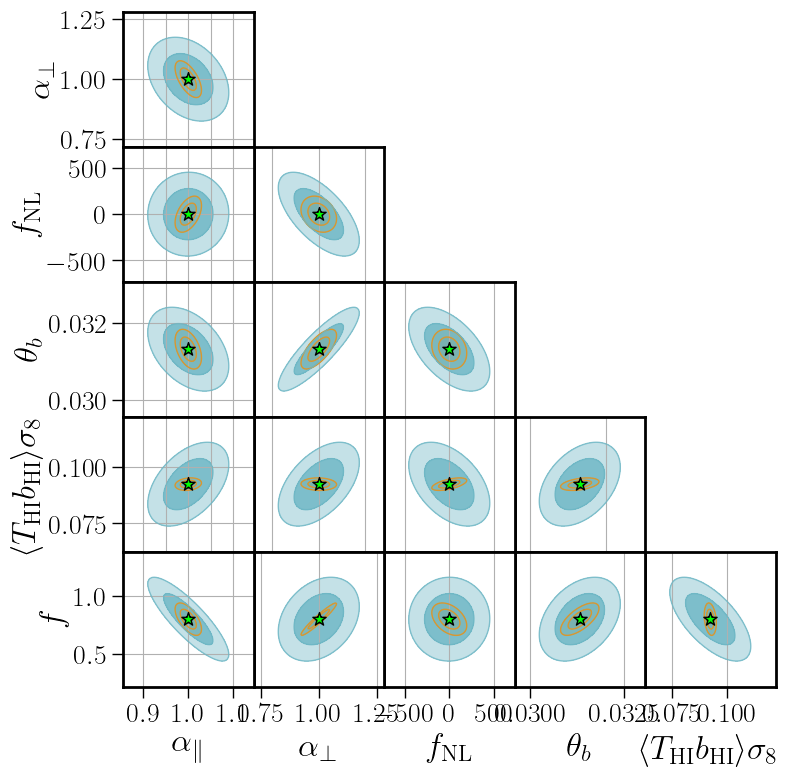

z =  0.8


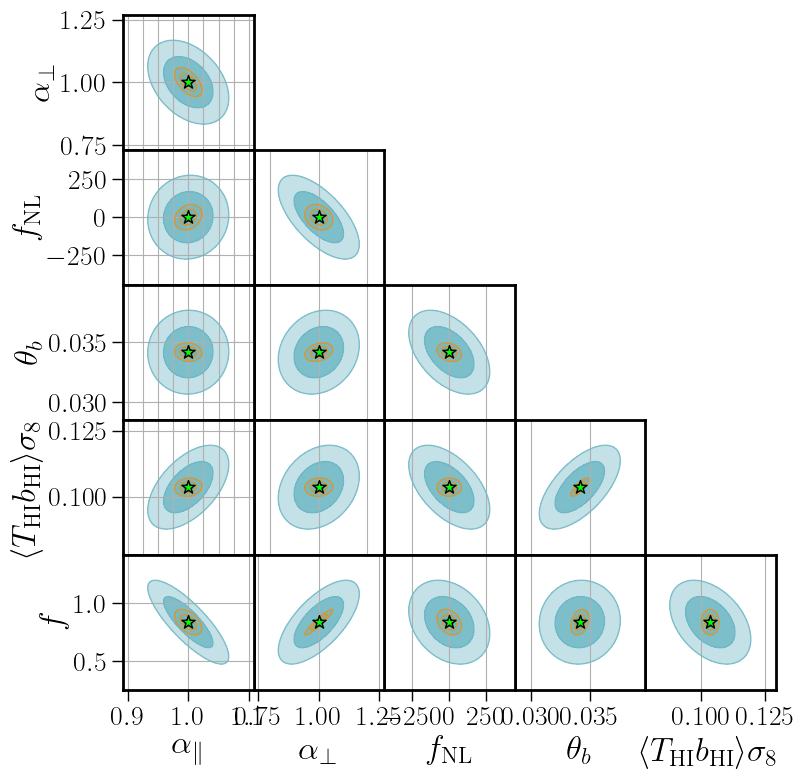

z =  1.0


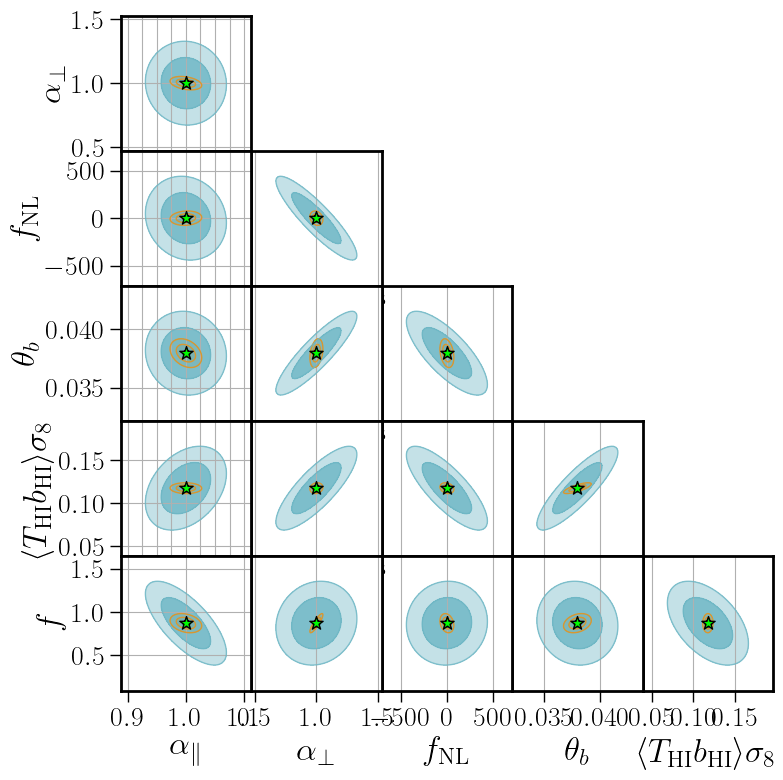

z =  1.2


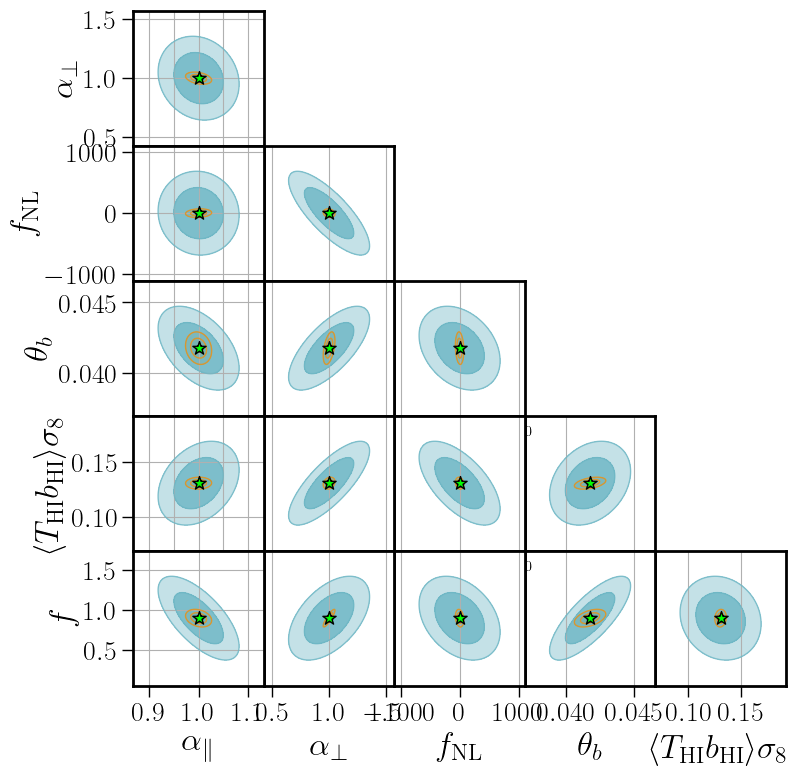

In [21]:
ZZ = [0.65,0.8,1.,1.2]
names = [r'$\alpha_\parallel$',r'$\alpha_\perp$',r'$f_{\rm NL}$',r'$\theta_b$',r'$\langle T_{\rm HI}b_{\rm HI}\rangle\sigma_8$',r'$f$']
NCOS = 6

for iz in range(len(ZZ)):
    zc = ZZ[iz]
    THI = THI_mean(zc)
    bHI = bHI_mean(zc)
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    Tbs8 = THI*bHI*s8
    f = M.fiducialcosmo.growth_rate(0.08/u.Mpc,zc,'clustering')
    D = 13.5*u.m #Diameter of dish
    beam = get_beam(zc,D)
    fiducial_set_vals = [1,1,0,beam.value,Tbs8.value,f]

    print('z = ',zc)
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(NCOS, NCOS,wspace=0,hspace=0,top=0.97,left=0.1,bottom=0.07,right=0.97)

    for i in range(NCOS-1)[::-1]:
        for j in range(i,NCOS-1):
            ax = plt.subplot(gs[j,i])
            #ax.locator_params(nbins=4,tight=True)
            center = np.array([fiducial_set_vals[i],fiducial_set_vals[j+1]])
            plot_2d(np.linalg.inv(FISHER_MKxDESI[iz]),[i,j+1],center,ax,color1=colors[2],color2=colors[2],filled=True,TwoSigma=True,zorder=5,alpha=[1.,0.5])
            plot_2d(np.linalg.inv(FISHER_MK[iz]),[i,j+1],center,ax,color1=colors[1],color2=colors[1],filled=True,TwoSigma=True,zorder=5,alpha=[0.8,0.4])
    
            ax.scatter(center[0],center[1],marker='*',s=100,color='lime',edgecolors='k',zorder=10)
            ax.grid()
            if j+1 == NCOS-1:
                ax.set_xlabel(names[i],fontsize=24)
                ax.tick_params(axis='both',width=1,length=8,labelsize=20)
            if i == 0:
                ax.set_ylabel(names[j+1],fontsize=24)
                ax.tick_params(axis='both',width=1,length=8,labelsize=20)
                if j + 1 < NCOS-1:
                    ax.tick_params(axis='x',width=1,length=8,labelsize=0)
            else:
                ax.set_yticks([])

    plt.show()

### MeerKLASS x 4MOST

In [186]:
#MK Auto
ZZ = [0.43,0.61]
DZ = [0.06,0.18]
FISHER_MK = []

Omega_field1 = 7.5e3*u.deg**2
Omega_field2 = 2.5e3*u.deg**2
ngal = (3.7e-4/Mpch**3).to(u.Mpc**-3)

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z1 = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MK2_z1 = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    FISHER_MK.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z1)[:NPAR,:NPAR]))



0.008434387453999645 1 / Mpc 0.09277826199399611 1 / Mpc 16
0.012164491681337186 1 / Mpc 0.09326110289025175 1 / Mpc 11
0.004962243328059045 1 / Mpc 0.0975907854518279 1 / Mpc 29
0.007156793307653961 1 / Mpc 0.0930383129995015 1 / Mpc 19


In [ ]:
#MK Auto
ZZ = [0.43,0.61]
DZ = [0.06,0.18]
FISHER_MKx4MOST = []

Omega_field1 = 2.5e3*u.deg**2
Omega_field2 = 0.5e3*u.deg**2
ngal = ????
Omega_field3 = 5e3*u.deg**2
Omega_field4 = 2e3*u.deg**2

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z1 = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MK2_z1 = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MKx4MOST1_z1 = do_fisher(M,zc,dz,Omega_field3,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'multi')
    Fisher_MKx4MOST2_z1 = do_fisher(M,zc,dz,Omega_field4,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'multi')
    FISHER_MKx4MOST.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxDESI1_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxDESI2_z1)[:NPAR,:NPAR]))



### MeerKLASS x Euclid spec

In [22]:
#MK Auto
ZZ = [1.,1.2]
DZ = [0.2,0.2]
FISHER_MK = []

Omega_field1 = 7.5e3*u.deg**2
Omega_field2 = 2.5e3*u.deg**2

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z1 = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    Fisher_MK2_z1 = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal,bg_DESI_4MOST_mean(zc),'auto')
    FISHER_MK.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z1)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z1)[:NPAR,:NPAR]))



0.003999202858794437 1 / Mpc 0.09731393623066463 1 / Mpc 36
0.005767848604668436 1 / Mpc 0.09805342627936342 1 / Mpc 25
0.00381194621804344 1 / Mpc 0.09783995292978162 1 / Mpc 38
0.005497777795008101 1 / Mpc 0.09712740771180978 1 / Mpc 26


In [24]:
#MK Auto
ZZ = [1.,1.2]
DZ = [0.2,0.2]
FISHER_MKxEuclid = []

Omega_field1 = 2.5e3*u.deg**2
Omega_field2 = 1.5e3*u.deg**2
ngal = [(6.86e-4/Mpch**3).to(u.Mpc**-3),(5.58e-4/Mpch**3).to(u.Mpc**-3)]
bg = [1.46,1.61]
Omega_field3 = 5e3*u.deg**2
Omega_field4 = 1e3*u.deg**2
Omega_field5 = 1.5e3*u.deg**2

NPAR = 6
for i in range(len(ZZ)):
    zc,dz = ZZ[i],DZ[i]
    Fisher_MK1_z = do_fisher(M,zc,dz,Omega_field1,tobs,Nd,ngal[i],bg[i],'auto')
    Fisher_MK2_z = do_fisher(M,zc,dz,Omega_field2,tobs,Nd,ngal[i],bg[i],'auto')
    Fisher_MKxEuclid1_z = do_fisher(M,zc,dz,Omega_field3,tobs,Nd,ngal[i],bg[i],'multi')
    Fisher_MKxEuclid2_z = do_fisher(M,zc,dz,Omega_field4,tobs,Nd,ngal[i],bg[i],'multi')
    Fisher_Euclid_z = do_fisher(M,zc,dz,Omega_field5,tobs,Nd,ngal[i],bg[i],'gal')
    FISHER_MKxEuclid.append(np.linalg.inv(np.linalg.inv(Fisher_MK1_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MK2_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxEuclid1_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_MKxEuclid2_z)[:NPAR,:NPAR])+
                     np.linalg.inv(np.linalg.inv(Fisher_Euclid_z)[:NPAR,:NPAR]))



0.005767848604668436 1 / Mpc 0.09805342627936342 1 / Mpc 25
0.00683854069441917 1 / Mpc 0.09346005615706199 1 / Mpc 20
0.00683854069441917 1 / Mpc 0.09346005615706199 1 / Mpc 20
0.005497777795008101 1 / Mpc 0.09712740771180978 1 / Mpc 26
0.006518336342879485 1 / Mpc 0.09777504514319227 1 / Mpc 22
0.006518336342879485 1 / Mpc 0.09777504514319227 1 / Mpc 22


z =  1.0


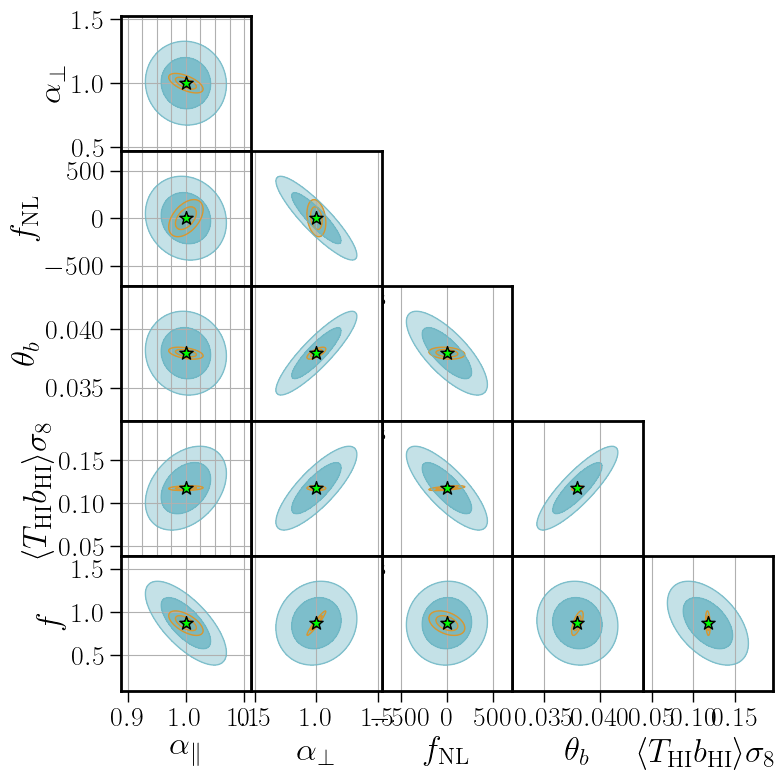

z =  1.2


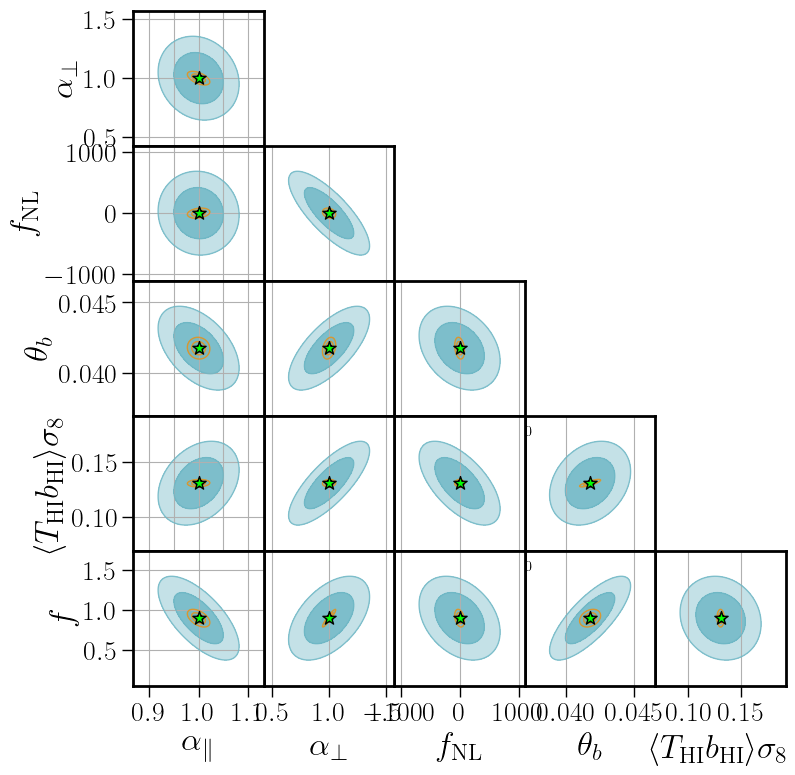

In [25]:
ZZ = [1.,1.2]
names = [r'$\alpha_\parallel$',r'$\alpha_\perp$',r'$f_{\rm NL}$',r'$\theta_b$',r'$\langle T_{\rm HI}b_{\rm HI}\rangle\sigma_8$',r'$f$']
NCOS = 6

for iz in range(len(ZZ)):
    zc = ZZ[iz]
    THI = THI_mean(zc)
    bHI = bHI_mean(zc)
    s8 = M.fiducialcosmo.sigma8_of_z(zc)
    Tbs8 = THI*bHI*s8
    f = M.fiducialcosmo.growth_rate(0.08/u.Mpc,zc,'clustering')
    D = 13.5*u.m #Diameter of dish
    beam = get_beam(zc,D)
    fiducial_set_vals = [1,1,0,beam.value,Tbs8.value,f]

    print('z = ',zc)
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(NCOS, NCOS,wspace=0,hspace=0,top=0.97,left=0.1,bottom=0.07,right=0.97)

    for i in range(NCOS-1)[::-1]:
        for j in range(i,NCOS-1):
            ax = plt.subplot(gs[j,i])
            #ax.locator_params(nbins=4,tight=True)
            center = np.array([fiducial_set_vals[i],fiducial_set_vals[j+1]])
            plot_2d(np.linalg.inv(FISHER_MKxDESI[iz]),[i,j+1],center,ax,color1=colors[2],color2=colors[2],filled=True,TwoSigma=True,zorder=5,alpha=[1.,0.5])
            plot_2d(np.linalg.inv(FISHER_MK[iz]),[i,j+1],center,ax,color1=colors[1],color2=colors[1],filled=True,TwoSigma=True,zorder=5,alpha=[0.8,0.4])
    
            ax.scatter(center[0],center[1],marker='*',s=100,color='lime',edgecolors='k',zorder=10)
            ax.grid()
            if j+1 == NCOS-1:
                ax.set_xlabel(names[i],fontsize=24)
                ax.tick_params(axis='both',width=1,length=8,labelsize=20)
            if i == 0:
                ax.set_ylabel(names[j+1],fontsize=24)
                ax.tick_params(axis='both',width=1,length=8,labelsize=20)
                if j + 1 < NCOS-1:
                    ax.tick_params(axis='x',width=1,length=8,labelsize=0)
            else:
                ax.set_yticks([])

    plt.show()